In [1]:
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, f1_score, roc_curve, auc,confusion_matrix
from sklearn import metrics

from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib inline

 # Data Exploration and preprocessing

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")


In [3]:
train_df.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'],
      dtype='object')

In [4]:
train_df['Dates']=pd.to_datetime(train_df['Dates'])
test_df['Dates']=pd.to_datetime(test_df['Dates'])
output_class_labels = train_df['Category'].unique()
print("Total Training data:",train_df.shape[0])
print("Total features:",train_df.shape[1])
train_df.head()


Total Training data: 878049
Total features: 9


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


# check for missing values

In [5]:
train_df.isnull().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [6]:
# no missing values feels good

# visualization

<Figure size 2160x2160 with 0 Axes>

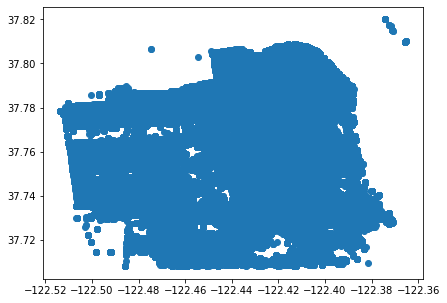

In [7]:
plt.figure(figsize = (30,30))
longitudes = train_df['X']
latitudes = train_df['Y']
subset=500000
latitudes=latitudes[0:subset]
longitudes=longitudes[0:subset]
plt.figure(figsize=(15,5))
plt.xlabel("Latituede",color ='#165880' )
plt.ylabel("Longatitue", color ='#165880')
plt.xticks(np.arange(-122.4, -122.6))
plt.yticks(np.arange(37.46, 37.85))
plt.subplot(1,2,1)
plt.scatter(longitudes, latitudes)
plt.show()



In [8]:
train_df['Date'] = train_df.iloc[:,0].apply(lambda x: x.day)
train_df['Month']=train_df.iloc[:,0].apply(lambda x: x.month)
train_df['Hour']=train_df.iloc[:,0].apply(lambda x: x.hour)

In [9]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Date,Month,Hour
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,13,5,23
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,13,5,23
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,13,5,23
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,13,5,23
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,13,5,23


In [10]:
train_df.drop('Dates', axis=1, inplace=True)
train_df.drop('Resolution', axis=1, inplace=True)
train_df.drop('Descript', axis=1, inplace=True)

In [11]:
# Most of teh Address variables could be usesful by checking if it contains the Keyword "BLOCK". SO lets create a feature Block_Ind which represents whether an addresss contains BLOCK word. In addition we will extract the Stree number form the address if present else will put as 0.

In [16]:

train_df['Block_Ind']  =train_df['Address'].apply(lambda x:1 if 'block'  in x.lower() else 0)
train_df['Street'] = train_df['Address'].apply(lambda x: x.split(" ")[0] if x.split(" ")[0].isnumeric() else 0)
train_df.drop('Address',axis = 1,inplace = True)



In [17]:
train_df.head()

,Category,DayOfWeek,PdDistrict,X,Y,Date,Month,Hour,Block_Ind,Street
0,WARRANTS,Wednesday,NORTHERN,-122.425892,37.774599,13,5,23,0,0
1,OTHER OFFENSES,Wednesday,NORTHERN,-122.425892,37.774599,13,5,23,0,0
2,OTHER OFFENSES,Wednesday,NORTHERN,-122.424363,37.800414,13,5,23,0,0
3,LARCENY/THEFT,Wednesday,NORTHERN,-122.426995,37.800873,13,5,23,1,1500
4,LARCENY/THEFT,Wednesday,PARK,-122.438738,37.771541,13,5,23,1,100


# normalize latitude and longitude

In [26]:
min_X = train_df['X'].min()
#std_X = train['X'].std()
min_Y = train_df['Y'].min()
#std_Y = train['Y'].std()
train_df['X'] = (train_df['X'] - min_X)
train_df['Y'] = (train_df['Y'] - min_Y)

In [27]:
train_df.head()

,Category,DayOfWeek,PdDistrict,X,Y,Date,Month,Hour,Block_Ind,Street
0,WARRANTS,Wednesday,NORTHERN,0.087750,0.066720,13,5,23,0,0
1,OTHER OFFENSES,Wednesday,NORTHERN,0.087750,0.066720,13,5,23,0,0
2,OTHER OFFENSES,Wednesday,NORTHERN,0.089279,0.092535,13,5,23,0,0
3,LARCENY/THEFT,Wednesday,NORTHERN,0.086647,0.092994,13,5,23,1,1500
4,LARCENY/THEFT,Wednesday,PARK,0.074904,0.063662,13,5,23,1,100


# Crime data based on Day of the Week, Date, Month and Hour of the Day

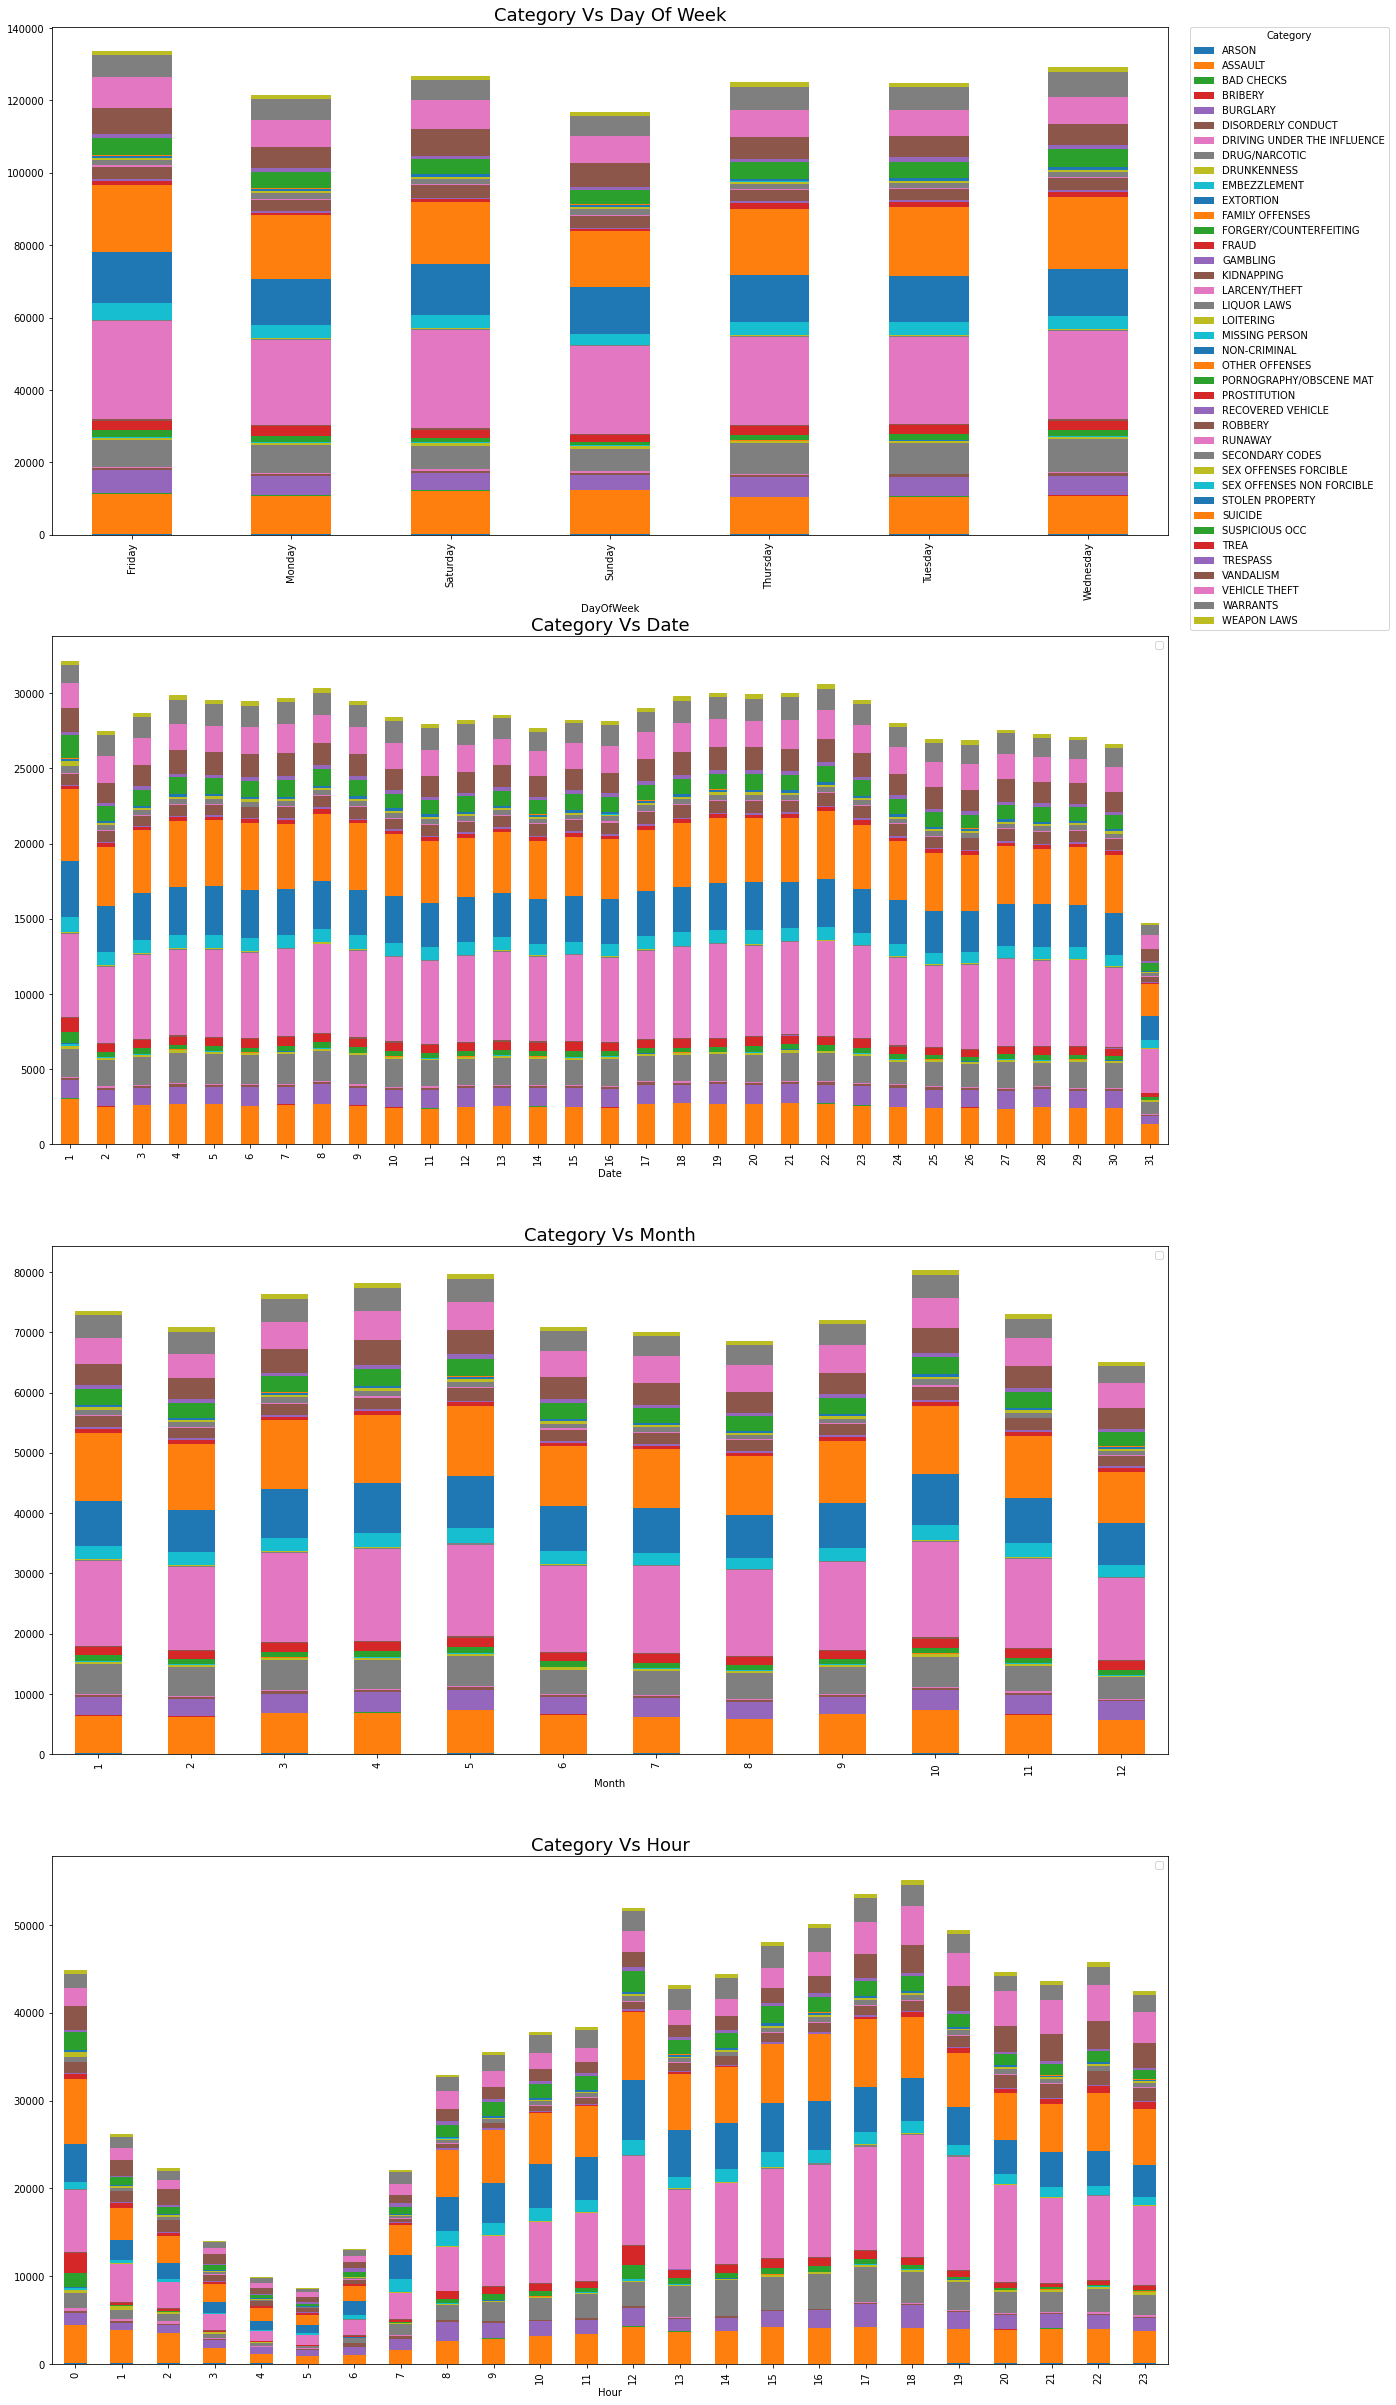

In [37]:
fig, ax= plt.subplots(nrows=4, ncols=1)
fig.set_size_inches(20, 43)
tmp=pd.crosstab(train_df.DayOfWeek, train_df.Category).plot.bar(stacked=True, ax=ax[0])
ax[0].legend(title='Category', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
ax[0].set_title("Category Vs Day Of Week", size=18)

tmp=pd.crosstab(train_df.Date, train_df.Category).plot.bar(stacked=True, ax=ax[1])
ax[1].legend([])
ax[1].set_title("Category Vs Date", size=18)


tmp=pd.crosstab(train_df.Month, train_df.Category).plot.bar(stacked=True, ax=ax[2])
ax[2].legend([])
ax[2].set_title("Category Vs Month", size=18)

tmp=pd.crosstab(train_df.Hour, train_df.Category).plot.bar(stacked=True, ax=ax[3])
ax[3].legend([])
ax[3].set_title("Category Vs Hour", size=18)
plt.show()

# visualization based on street number

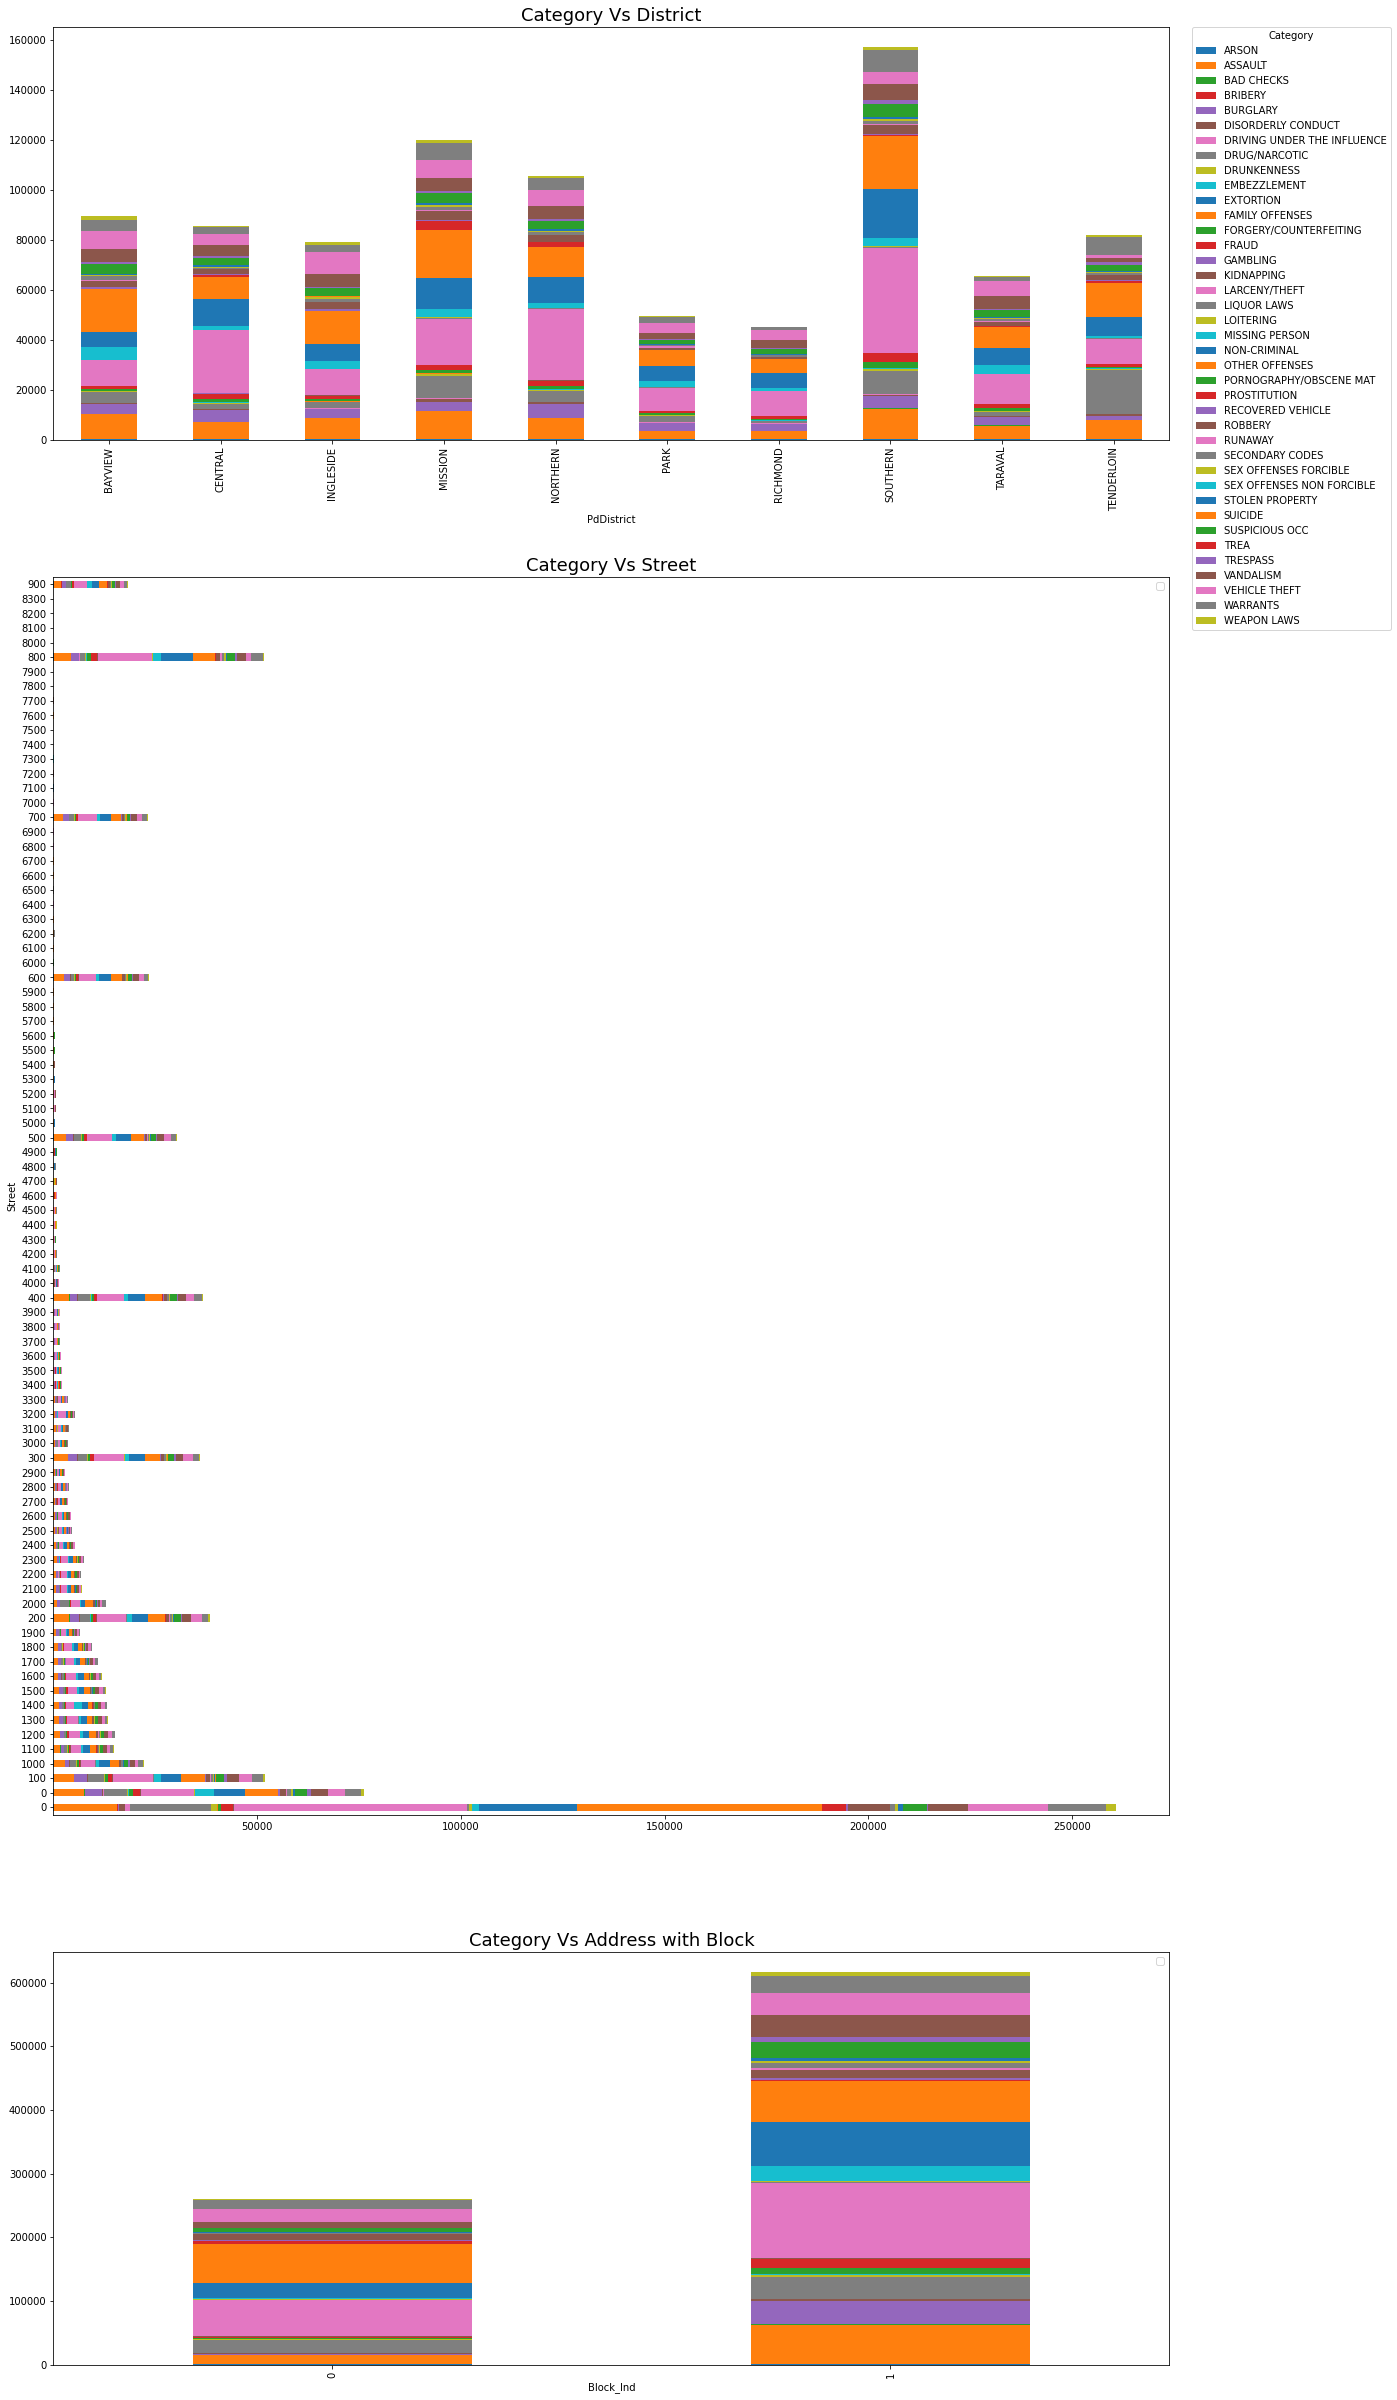

In [40]:
fig, ax= plt.subplots(nrows=3, ncols=1, gridspec_kw = {'height_ratios':[1, 3, 1]})
fig.set_size_inches(20, 43)
tmp=pd.crosstab(train_df.PdDistrict, train_df.Category).plot.bar(stacked=True, ax=ax[0])
ax[0].legend(title='Category', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
ax[0].set_title("Category Vs District", size=18)
tmp=pd.crosstab(train_df.Street, train_df.Category).plot.barh(stacked=True, ax=ax[1])
ax[1].legend([])
ax[1].set_title("Category Vs Street", size=18)

tmp=pd.crosstab(train_df.Block_Ind, train_df.Category).plot.bar(stacked=True, ax=ax[2])
ax[2].legend([])
ax[2].set_title("Category Vs Address with Block", size=18)
plt.show()

# feature engineering

In [45]:
def transform_feature(df):
    hour = df['Hour']
    date = df['Date']
    month=df['Month']
    longitude=df["X"]
    lattitude=df["Y"]
    block= df['Block_Ind']
    street=df['Month']
    
    #Get a binary vector for these variables and create columns
    weekday = pd.get_dummies(df['DayOfWeek'])
    district  = pd.get_dummies(df['PdDistrict'])
    return pd.concat([hour, date, month, weekday, district, block, street, lattitude, longitude],axis =1)


encoder = preprocessing.LabelEncoder()
category = train_df['Category']
train_transformed  = transform_feature(train_df)
train_transformed['Category']  = encoder.fit_transform(category)


    

# split data in trian and validation set

In [48]:
train_data=train_transformed.sample(frac=0.8,random_state=200)
validation_data=train_transformed.drop(train_data.index)

train_features=train_data.iloc[:,0:train_transformed.shape[1]-1]
train_labels=train_data.iloc[:,train_transformed.shape[1]-1]
validation_features=validation_data.iloc[:,0:train_transformed.shape[1]-1]
validation_labels=validation_data.iloc[:,train_transformed.shape[1]-1]

print(train_features.shape)
print(validation_features.shape)


(702439, 24)
(175610, 24)


In [49]:
def get_next_batch(data, labels, batch_size, batch_number):
    # This method is used to feed the batch of images to train the model
    start_index = batch_number*batch_size
    end_index = batch_size*(batch_number+1)
    return np.array(data[start_index:end_index]), np.array(labels[start_index:end_index])

def dummy_encoding(labels):
    # This function is use to teh binary encoding of teh labels
    n_class = np.unique(labels).shape[0]
    with tf.Session() as sess:
        labels = sess.run(tf.one_hot(labels, n_class))
    return labels

# Buid the model

In [ ]:
%time
logistic_model=LogisticRegression(max_iter =100000)#penalty='l2', tol=0)
model_data_file="logistic_classifer_model.dat"
logistic_model.fit(train_features,train_labels)
predicted_prob=logistic_model.predict_proba(train_features)

Wall time: 0 ns
